In [1]:
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, Concatenate
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import plot_model
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.patheffects as PathEffects
import seaborn as sns
import my_util as mu
import random



Using TensorFlow backend.


In [2]:
(tr_img,tr_label),(te_img,te_label) = keras.datasets.mnist.load_data()

tr_img = tr_img.astype('float32')
te_img = te_img.astype('float32')

tr_img /= 255
te_img /= 255

reshape_tr_img = tr_img.reshape([tr_img.shape[0]] + list(tr_img.shape[1:]) + [1])
reshape_te_img = te_img.reshape([te_img.shape[0]] + list(te_img.shape[1:]) + [1])


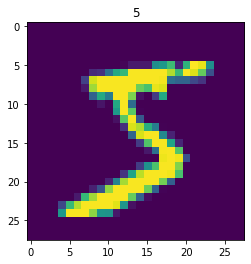

In [3]:
plt.imshow(tr_img[0])
plt.title(tr_label[0])
plt.show()


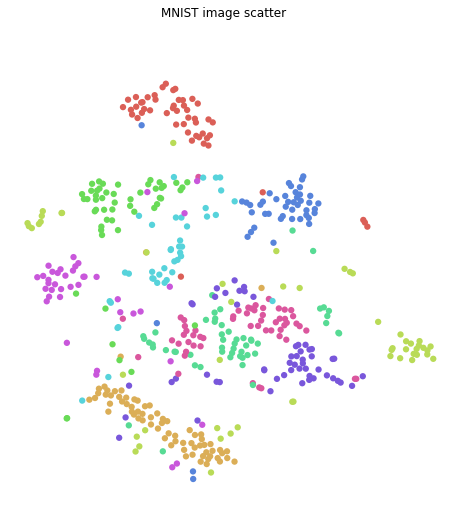

In [4]:
# トレーニング画像の散布図を描画
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(tr_img.reshape(-1,tr_img.shape[1] * tr_img.shape[2])[:512])
mu.scatter(train_tsne_embeds, tr_label[:512], 10, "MNIST image scatter")


In [5]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(input)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input,x)

def euclidean_distance(vects):
    x,y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.square(K.maximum(sum_square,K.epsilon()))

def contrastive_loss(y_true, y_pred):
    margin = 1
    positive_d = y_pred[:,0]
    negative_d = y_pred[:,1]
    return K.maximum(positive_d - negative_d + margin,0)

def create_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]

    image_set = []
    anckor_label = []

    for class_index in range(10):
        indices = digit_indices[class_index] 
        for i in indices[:128]:
            anckor_img = images[i]
            positive_i = indices[(random.randrange(1,len(indices)) + i) % len(indices)]
            positive_img = images[positive_i]

            negative_indices = digit_indices[(random.randrange(1,10) + class_index) % 10]
            negative_i = negative_indices[random.randrange(0,len(negative_indices))]
            negative_img = images[negative_i]
            image_set += [[anckor_img, positive_img, negative_img]]
            anckor_label += [class_index]

    return np.array(image_set), np.array(anckor_label)


In [6]:
image_set, anckor_label = create_set(reshape_tr_img,tr_label)
te_image_set, te_anckor_label = create_set(reshape_te_img,te_label)


In [7]:
image_set.shape


(1280, 3, 28, 28, 1)

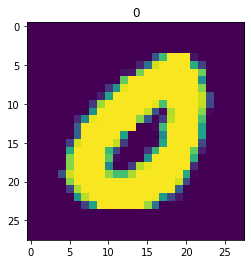

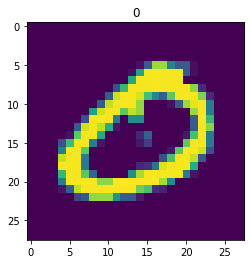

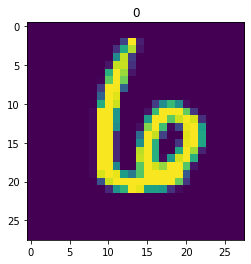

In [8]:
# 画像セットの確認
img = image_set[127][0]
plt.imshow(img.reshape(img.shape[0],img.shape[1]))
plt.title(anckor_label[0])
plt.show()
img = image_set[127][1]
plt.imshow(img.reshape(img.shape[0],img.shape[1]))
plt.title(anckor_label[0])
plt.show()
img = image_set[127][2]
plt.imshow(img.reshape(img.shape[0],img.shape[1]))
plt.title(anckor_label[0])
plt.show()


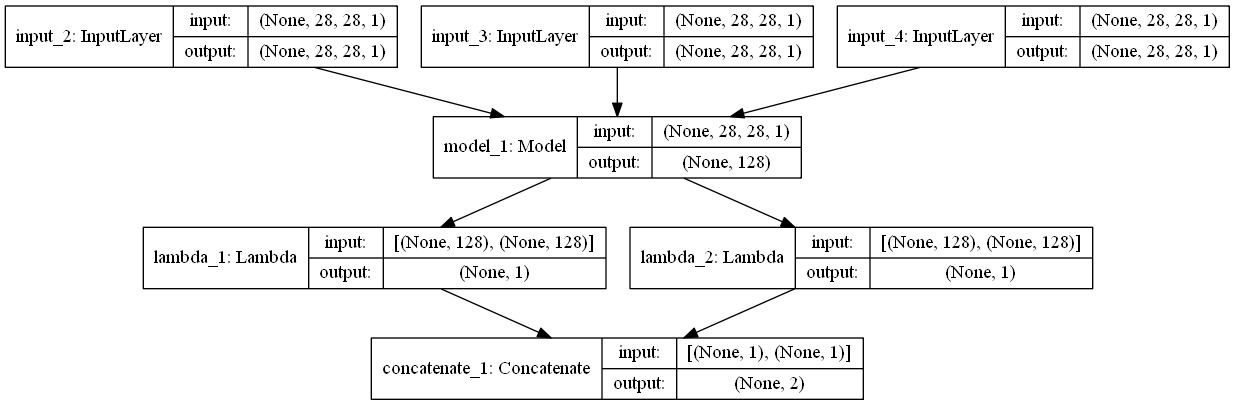

In [9]:
input_shape = reshape_tr_img.shape[1:]

base_network = create_base_network(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_anchor = base_network(input_anchor)
processed_positive = base_network(input_positive)
processed_negative = base_network(input_negative)

distance_positive = Lambda(euclidean_distance)([processed_anchor,processed_positive])
distance_negative = Lambda(euclidean_distance)([processed_anchor,processed_negative])

concat = Concatenate(axis=1)([distance_positive, distance_negative])

model = Model([input_anchor,input_positive,input_negative],concat)
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)

plot_model(model, to_file='model.png', show_shapes=True)


In [10]:
history = model.fit([image_set[:,0], image_set[:,1], image_set[:,2]], anckor_label, batch_size=128, epochs=10, validation_data=([te_image_set[:,0], te_image_set[:,1], te_image_set[:,2]], te_anckor_label))


Train on 1280 samples, validate on 1280 samples
Epoch 1/10
1280/1280 [==============================] - 8s 6ms/step - loss: 349.9736 - val_loss: 0.7827
Epoch 2/10
1280/1280 [==============================] - 7s 5ms/step - loss: 1.2167 - val_loss: 0.5891
Epoch 3/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.5148 - val_loss: 0.4898
Epoch 4/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.3546 - val_loss: 0.4046
Epoch 5/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.2920 - val_loss: 0.4009
Epoch 6/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.2433 - val_loss: 0.3621
Epoch 7/10
1280/1280 [==============================] - 7s 6ms/step - loss: 0.2153 - val_loss: 0.3326
Epoch 8/10
1280/1280 [==============================] - 6s 5ms/step - loss: 0.1742 - val_loss: 0.3094
Epoch 9/10
1280/1280 [==============================] - 6s 5ms/step - loss: 0.1394 - val_loss: 0.4919
Epoch 10/10
1280/1280 [=========

In [11]:
pred = model.predict([image_set[:,0], image_set[:,1], image_set[:,2]])
pred.shape


(1280, 2)

In [12]:
pred[0]


array([ 0.9321309, 12.773699 ], dtype=float32)

In [13]:
output_layer = None
input_layer = None
layer = model.layers[3]
print(layer.name)
output_layer = layer.get_output_at(0)
print(output_layer)
input_layer = layer.get_input_at(0)
print(input_layer)

active_model = Model(inputs=input_layer,outputs=output_layer)
active_model.summary()

# %%


model_1
Tensor("dense_2/Relu:0", shape=(None, 128), dtype=float32)
Tensor("input_1:0", shape=(None, 28, 28, 1), dtype=float32)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4718720   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0        

In [14]:

# %%


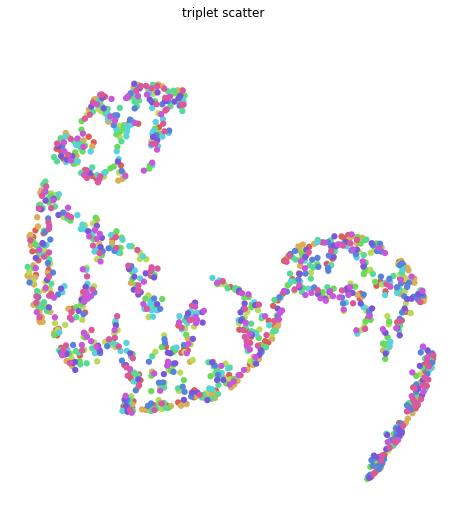

In [15]:
train_tsne_embeds = tsne.fit_transform(pred)
mu.scatter(train_tsne_embeds, anckor_label, 10, "triplet scatter")



# %%


In [16]:
breakpoint()
output_layer = None
input_layer = None
layer = model.layers[3]
print(layer.name)
output_layer = layer.get_output_at(0)
print(output_layer)
input_layer = layer.get_input_at(0)
print(input_layer)

active_model = Model(inputs=input_layer,outputs=output_layer)
active_model.summary()


model_1
Tensor("dense_2/Relu:0", shape=(None, 128), dtype=float32)
Tensor("input_1:0", shape=(None, 28, 28, 1), dtype=float32)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4718720   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0        

In [17]:
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, Concatenate
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import plot_model
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.patheffects as PathEffects
import seaborn as sns
import my_util as mu
import random



In [18]:
(tr_img,tr_label),(te_img,te_label) = keras.datasets.mnist.load_data()

tr_img = tr_img.astype('float32')
te_img = te_img.astype('float32')

tr_img /= 255
te_img /= 255

reshape_tr_img = tr_img.reshape([tr_img.shape[0]] + list(tr_img.shape[1:]) + [1])
reshape_te_img = te_img.reshape([te_img.shape[0]] + list(te_img.shape[1:]) + [1])


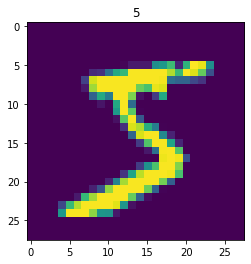

In [19]:
plt.imshow(tr_img[0])
plt.title(tr_label[0])
plt.show()


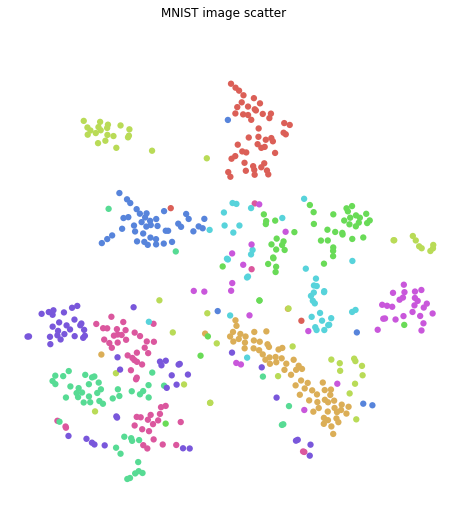

In [20]:
# トレーニング画像の散布図を描画
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(tr_img.reshape(-1,tr_img.shape[1] * tr_img.shape[2])[:512])
mu.scatter(train_tsne_embeds, tr_label[:512], 10, "MNIST image scatter")


In [21]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(input)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input,x)

def euclidean_distance(vects):
    x,y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.square(K.maximum(sum_square,K.epsilon()))

def contrastive_loss(y_true, y_pred):
    margin = 1
    positive_d = y_pred[:,0]
    negative_d = y_pred[:,1]
    return K.maximum(positive_d - negative_d + margin,0)

def create_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]

    image_set = []
    anckor_label = []

    for class_index in range(10):
        indices = digit_indices[class_index] 
        for i in indices[:128]:
            anckor_img = images[i]
            positive_i = indices[(random.randrange(1,len(indices)) + i) % len(indices)]
            positive_img = images[positive_i]

            negative_indices = digit_indices[(random.randrange(1,10) + class_index) % 10]
            negative_i = negative_indices[random.randrange(0,len(negative_indices))]
            negative_img = images[negative_i]
            image_set += [[anckor_img, positive_img, negative_img]]
            anckor_label += [class_index]

    return np.array(image_set), np.array(anckor_label)


In [22]:
image_set, anckor_label = create_set(reshape_tr_img,tr_label)
te_image_set, te_anckor_label = create_set(reshape_te_img,te_label)


In [23]:
image_set.shape


(1280, 3, 28, 28, 1)

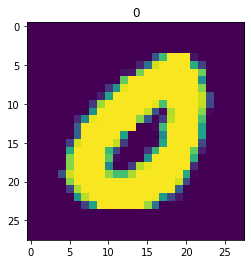

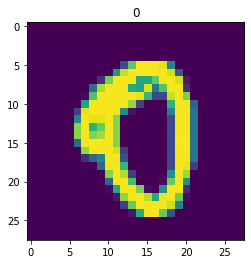

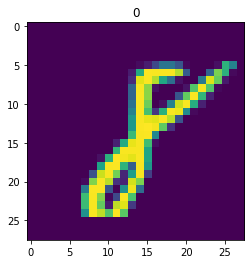

In [24]:
# 画像セットの確認
img = image_set[127][0]
plt.imshow(img.reshape(img.shape[0],img.shape[1]))
plt.title(anckor_label[0])
plt.show()
img = image_set[127][1]
plt.imshow(img.reshape(img.shape[0],img.shape[1]))
plt.title(anckor_label[0])
plt.show()
img = image_set[127][2]
plt.imshow(img.reshape(img.shape[0],img.shape[1]))
plt.title(anckor_label[0])
plt.show()


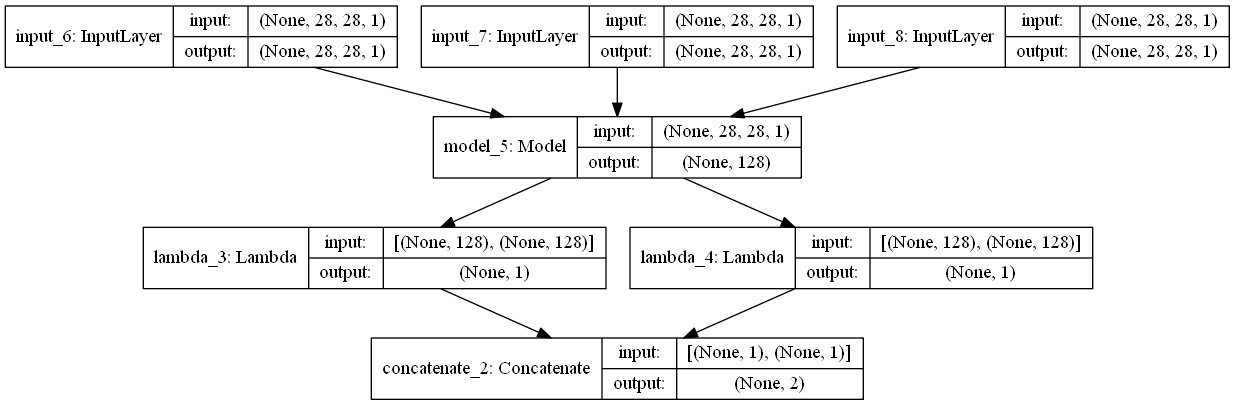

In [25]:
input_shape = reshape_tr_img.shape[1:]

base_network = create_base_network(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_anchor = base_network(input_anchor)
processed_positive = base_network(input_positive)
processed_negative = base_network(input_negative)

distance_positive = Lambda(euclidean_distance)([processed_anchor,processed_positive])
distance_negative = Lambda(euclidean_distance)([processed_anchor,processed_negative])

concat = Concatenate(axis=1)([distance_positive, distance_negative])

model = Model([input_anchor,input_positive,input_negative],concat)
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)

plot_model(model, to_file='model.png', show_shapes=True)


In [26]:
history = model.fit([image_set[:,0], image_set[:,1], image_set[:,2]], anckor_label, batch_size=128, epochs=10, validation_data=([te_image_set[:,0], te_image_set[:,1], te_image_set[:,2]], te_anckor_label))


Train on 1280 samples, validate on 1280 samples
Epoch 1/10
1280/1280 [==============================] - 5s 4ms/step - loss: 388.9801 - val_loss: 0.8044
Epoch 2/10
1280/1280 [==============================] - 5s 4ms/step - loss: 1.4244 - val_loss: 0.5537
Epoch 3/10
1280/1280 [==============================] - 6s 5ms/step - loss: 0.7950 - val_loss: 0.4768
Epoch 4/10
1280/1280 [==============================] - 6s 5ms/step - loss: 0.4724 - val_loss: 0.4125
Epoch 5/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.3162 - val_loss: 0.3601
Epoch 6/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.2124 - val_loss: 0.3543
Epoch 7/10
1280/1280 [==============================] - 6s 5ms/step - loss: 0.1494 - val_loss: 0.3117
Epoch 8/10
1280/1280 [==============================] - 7s 6ms/step - loss: 0.1444 - val_loss: 0.3316
Epoch 9/10
1280/1280 [==============================] - 7s 5ms/step - loss: 0.1412 - val_loss: 0.3976
Epoch 10/10
1280/1280 [=========

In [27]:
pred = model.predict([image_set[:,0], image_set[:,1], image_set[:,2]])
pred.shape


(1280, 2)

In [28]:
pred[0]


array([0.25787863, 2.7691386 ], dtype=float32)

In [29]:
output_layer = None
input_layer = None
layer = model.layers[3]
print(layer.name)
output_layer = layer.get_output_at(0)
print(output_layer)
input_layer = layer.get_input_at(0)
print(input_layer)

active_model = Model(inputs=input_layer,outputs=output_layer)
active_model.summary()


model_5
Tensor("dense_4/Relu:0", shape=(None, 128), dtype=float32)
Tensor("input_5:0", shape=(None, 28, 28, 1), dtype=float32)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4718720   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0        

In [30]:
pred = active_model.predict([image_set[:,0]])


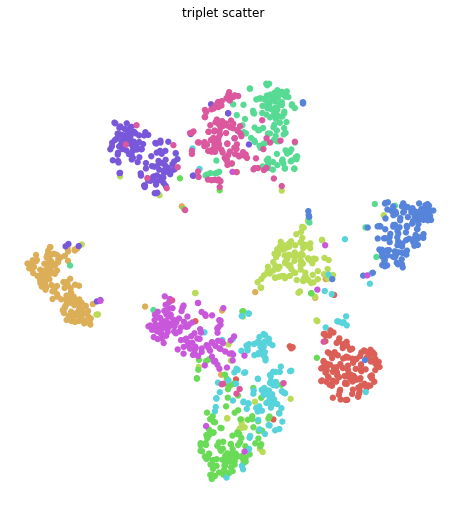

In [31]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(pred)
mu.scatter(train_tsne_embeds, anckor_label, 10, "triplet scatter")


